In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy.stats import chi2_contingency, norm
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelBinarizer

# EDA

In [2]:
df = pd.read_csv("./data/train.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
def check_empty(ts):
    if ts.isna().any():
        print("Hay vacios en columna ", ts.name)
        print(ts.isna().sum())

Check for empty columns on training

In [4]:
for col in df.columns:
    check_empty(df[col])

Hay vacios en columna  Age
177
Hay vacios en columna  Cabin
687
Hay vacios en columna  Embarked
2


Identify possible distributions between all `embarked` classes

In [5]:
df.fillna({'Embarked':'U'}).query("Embarked == 'Q'").Fare.describe()

count    77.000000
mean     13.276030
std      14.188047
min       6.750000
25%       7.750000
50%       7.750000
75%      15.500000
max      90.000000
Name: Fare, dtype: float64

In [6]:
df.fillna({'Embarked':'U'}).query("Embarked == 'S'").Fare.describe()

count    644.000000
mean      27.079812
std       35.887993
min        0.000000
25%        8.050000
50%       13.000000
75%       27.900000
max      263.000000
Name: Fare, dtype: float64

In [7]:
df.fillna({'Embarked':'U'}).query("Embarked == 'C'").Fare.describe()

count    168.000000
mean      59.954144
std       83.912994
min        4.012500
25%       13.697950
50%       29.700000
75%       78.500025
max      512.329200
Name: Fare, dtype: float64

Seems all `Embarked` classes have different distributions. So it is possible to impute `Embarked` using `Fare` as main variable

In [8]:
def impute_embarked(df):
    grouped_data = df.groupby("Embarked")
    
    fare_distributions = {name: norm.fit(group['Fare']) for name, group in grouped_data}
        
    df = df.assign(
        most_likely_class = lambda df: df.Fare.map(
            lambda ts: {embarked: norm.pdf(ts, distribution[0], distribution[1]) for embarked, distribution in fare_distributions.items()}
        ).map(max)
    )

    df.fillna({'Embarked': df.most_likely_class}, inplace=True)
    
    return df

In [9]:
df = impute_embarked(df)

To impute Age I decided to study different distributions

Null hypothesis: The Age variable is a sample of a normal distributions with a 95% of confidence. Becuase of the p values is lower than 0.05, then I reject the null hypothesis.

In [10]:
from scipy import stats

loc, scale = df.Age.dropna().mean(), df.Age.dropna().std()
cdf = stats.norm(loc, scale).cdf
stats.ks_1samp(df.Age.dropna(), cdf)

KstestResult(statistic=0.06456656793494475, pvalue=0.004958146899084225, statistic_location=30.0, statistic_sign=1)

In [11]:
def perform_chi2_test(data, categorical_column, binary_column):
    contingency_table = pd.crosstab(data[categorical_column], data[binary_column])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    return chi2, p, dof, expected, contingency_table

Perform chi2 test to see dependency between age and other variables. Also, testing Phi coefficient to have another reference.

In [12]:
df['age_encoded'] = df.Age.isna().astype(int)

# Perform chi-square tests
chi2_pclass, p_pclass, dof_pclass, expected_pclass, ct_pclass = perform_chi2_test(df, 'Pclass', 'age_encoded')
chi2_embarked, p_embarked, dof_embarked, expected_embarked, ct_embarked = perform_chi2_test(df, 'Embarked', 'age_encoded')
chi2_sex, p_sex, dof_sex, expected_sex, ct_sex = perform_chi2_test(df, 'Sex', 'age_encoded')

print("Pclass and age_encoded:", chi2_pclass, p_pclass)
print("Embarked and age_encoded:", chi2_embarked, p_embarked)
print("Sex and age_encoded:", chi2_sex, p_sex)

Pclass and age_encoded: 46.06266379338537 9.945340263413207e-11
Embarked and age_encoded: 107.75883194228521 3.985354475426952e-24
Sex and age_encoded: 2.4344385997085913 0.11869638287527425


In [13]:
def phi_coefficient(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    return np.sqrt(chi2 / n)

In [14]:
phi_coefficient_value_pclass = phi_coefficient(ct_pclass)
phi_coefficient_value_embarked = phi_coefficient(ct_embarked)

print("Phi coefficient Pclass:", phi_coefficient_value_pclass)
print("Phi coefficient Embarked:", phi_coefficient_value_embarked)

Phi coefficient Pclass: 0.22737131458290322
Phi coefficient Embarked: 0.3477663727149901


Previous tests didn't provided enough evidence to accept null hypothesis, I looked into strata in case there are some connections between variables.

In [15]:
def stratified_chi2_test(data, stratifier_columns, categorical_column, binary_column):
    for level in data[stratifier_columns].unique():
        stratified_data = df[df[stratifier_columns] == level]
        contingency_table = pd.crosstab(stratified_data[categorical_column], stratified_data[binary_column])
        chi2, p = chi2_contingency(contingency_table)[0:2]
        print(f"Stratum: {level}, Chi-square: {chi2:.2f}, p-value: {p:.4f}")

In [16]:
stratified_chi2_test(df, 'Pclass', 'Embarked', 'age_encoded')
stratified_chi2_test(df, 'Embarked', 'Pclass', 'age_encoded')

Stratum: 3, Chi-square: 75.12, p-value: 0.0000
Stratum: 1, Chi-square: 0.46, p-value: 0.7935
Stratum: 2, Chi-square: 5.36, p-value: 0.0686
Stratum: S, Chi-square: 15.79, p-value: 0.0004
Stratum: C, Chi-square: 14.47, p-value: 0.0007
Stratum: Q, Chi-square: 4.98, p-value: 0.0831


Stratum 1 in Pclass has enough evidence to accept null hypothesis. Age imputation will be based on Pclass and Embarked

In [17]:
def stratified_mean_imputation(df, target_column, group_columns):
    df_copy = df.copy()
    for group_name, group_data in df_copy.groupby(group_columns):
        mean_value = group_data[target_column].mean()
        df_copy.loc[((df_copy[['Sex','Pclass','Embarked']] == group_name).all(axis=1) & df_copy['Age'].isna()), 'Age'] = mean_value
    return df_copy.Age

df['Age_imputed'] = stratified_mean_imputation(df, 'Age', ['Sex','Pclass','Embarked'])

I looked into Fare distribution and plotting a box to look for outliers.

<Axes: ylabel='Frequency'>

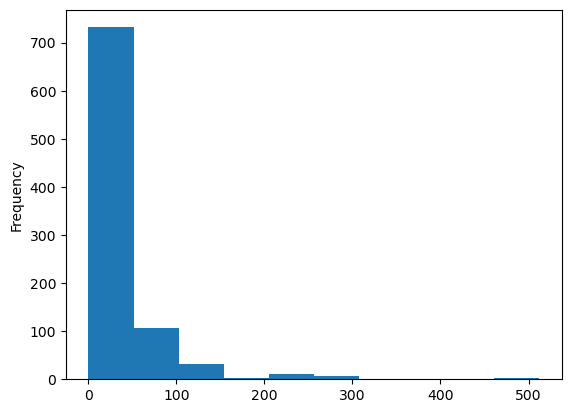

In [18]:
df.Fare.plot.hist()

<Axes: >

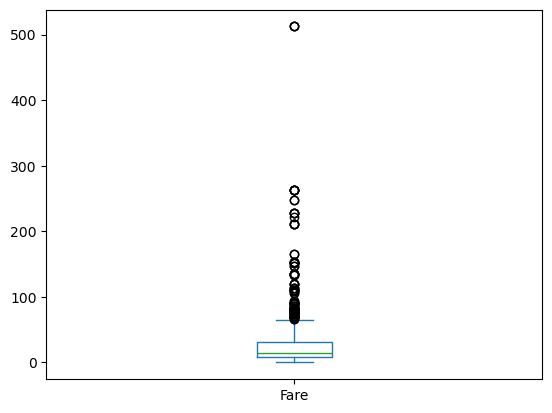

In [19]:
df.Fare.plot.box()

I create a function to cap outliers using Box-Cox method.

In [20]:
def cap_outliers(data, column, num_stds=3, epsilon=1e-6):
    # Fill empty values with mean
    data[column].fillna(data[column].mean(), inplace=True)
    
    # Add a very small value to handle values near 0 or 0
    data[column] += epsilon
    
    # Transform the data using a log
    log_data = np.log(data[column])
    
    # Calculate mean and standard deviation
    q1 = np.quantile(log_data, 0.25)
    q3 = np.quantile(log_data, 0.75)
    iqr = q3 - q1
    
    # Define outlier bonds
    lower_bound = q1 - num_stds * iqr
    upper_bound = q3 + num_stds * iqr
    
    # Cap outliers
    capped_log_data = np.clip(log_data, lower_bound, upper_bound)
    
    # Inverse transformation
#     capped_data = np.exp(capped_log_data)
    return capped_log_data

<Axes: ylabel='Frequency'>

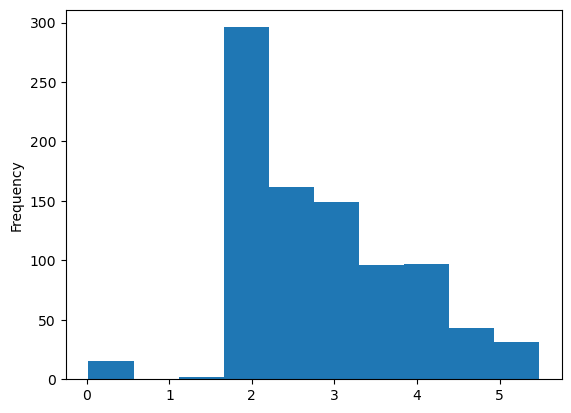

In [21]:
cap_outliers(df, 'Fare', 1.5).plot.hist()

Encode multiple variables and create a prototype of the transformation flow.

In [22]:
from sklearn.preprocessing import OneHotEncoder

pclass_encoder = OneHotEncoder(sparse_output=False)
embarked_encoder = OneHotEncoder(sparse_output=False)
sex_encoder = LabelBinarizer()

Pclass_Encoded = pclass_encoder.fit_transform(df[['Pclass']])
Embarked_Encoded = embarked_encoder.fit_transform(df[['Embarked']])
Sex_Encoded = sex_encoder.fit_transform(df[['Sex']])

df['Sex'] = Sex_Encoded

data = pd.concat(
    [df.filter(['Sex','Age_imputed','SibSp','Parch','new_fare','Survived']),
     pd.DataFrame(
        data=Pclass_Encoded,
        columns=pclass_encoder.get_feature_names_out()
    ),
    pd.DataFrame(
        data=Embarked_Encoded,
        columns=embarked_encoder.get_feature_names_out()
    )],
    axis=1
)

In [23]:
y = data[['Survived']]
X = data.drop(columns='Survived')

In [24]:
X.rename(
    columns={'Age_imputed':'Age', 'new_fare':'Fare'},
    inplace=True
)

In [25]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [26]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y.values[:,0], test_size=0.33)

clf = SVC(class_weight='balanced', random_state=42)
# I performed a grid serch, however the number of parameters increase the computation time.
# params = {
#     'C': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],
#     'kernel': ['poly','rbf','sigmoid'],
#     'degree': [3,4,5,6,7,8,9,10]
# }

# grid = GridSearchCV(clf, param_grid=params, cv=5)
# grid.fit(X_train, y_train)

clf.fit(X_train, y_train)

SVC(class_weight='balanced', random_state=42)

In [27]:
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.85      0.90      0.87       193
           1       0.78      0.71      0.74       102

    accuracy                           0.83       295
   macro avg       0.82      0.80      0.81       295
weighted avg       0.83      0.83      0.83       295



<Axes: >

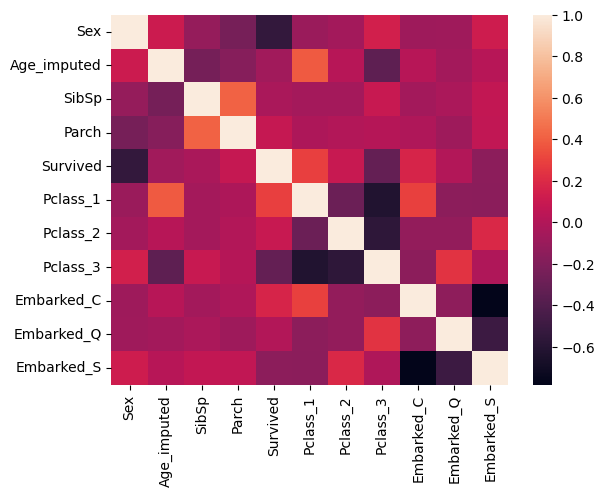

In [33]:
import seaborn as sns

sns.heatmap(data.corr())

# Model performance
The model performs good overall with a f1 score above 0.8. It shows difficulty to classify `1` class, so further investigation for new variables should be done in future releases.

# Variables
Looking at the correlation map to understand relationship between each other and `Survived`, we can say `Sex` is one of the most important variables inside the dataset since its correlation with the target variable is string negative correlated. Considerations inside the data:
1. There are correlation between Pclasses, particularly with `Pclass_3`
2. The same occurrs with `Embarked_S`, strong negative correlation with other Emberked categories.

# Production Model
## MLOps Best practices
Strating by versioning absolutly everything to ensure all experiments are stored somewhere and can be retrieved when needed, they be helpful to make comparision. This relates with experiment traking, getting records of all experiments, architectures, hyperparameters and datasets.

Create a CI/CD environment to automate building, testing and deploying process. Including a model monitoring with the main KPIs to always keep track on model's performance and decided when a retraining is needed.

Additional practices to take into consideration:
- Stablishing data quality standards and validation processes.
- Data versioning and lineage tracking
- Ensuring data privacy
- Prioritize model explainability and interpretability

## Tools and system architecture
To ensure CI/CD automation, version control, GitHub is an alternative.
For experimentation tracking, MLFlow
For model deployment usein AWS will help. Considering integrating with Kubernetes or AWS Sagemaker.